<a href="https://colab.research.google.com/github/SelimSavas/PyTorchImageSegmentation/blob/main/AerialImageSegmentationPyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 14.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16445 sha256=faa5ea5290116b2f21864ae3d6bae996f1fcb9597500f3a308765b1bcdc1470a
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60963 sha256=87467e6f9d47a6c86b98d896ab8d24015a435eeaaeb637e24d8bb26b720f381f
  Stored in directory: /root/.cache/pip/w

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset 

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

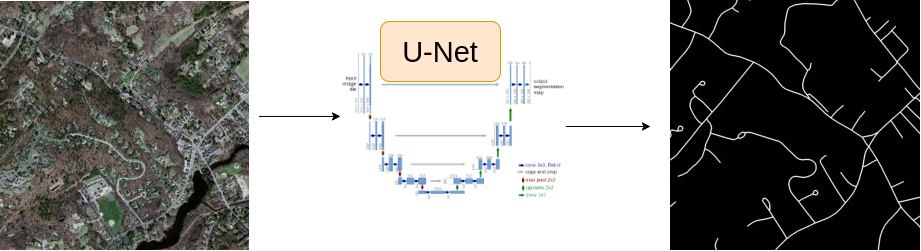

# Download Subset Dataset

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 31.58 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [147]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [148]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
BATCH_SIZE = 4
IMG_SIZE = 256

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [149]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [150]:
idx = 3

row = df.iloc[idx]

image_path = DATA_DIR +row.images
mask_path = DATA_DIR + row.masks


image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255

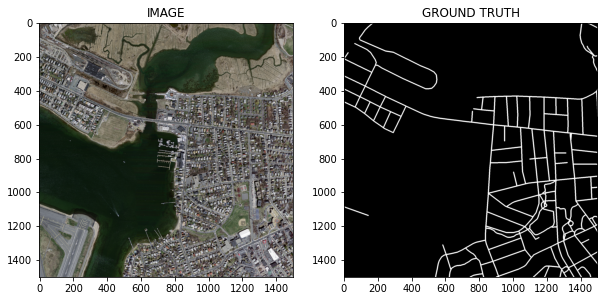

In [151]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [152]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

In [172]:
train_df = train_df[:120]

In [174]:
len(train_df)

120

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [175]:
import albumentations as A

In [176]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset 

In [177]:
from torch.utils.data import Dataset

In [178]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = df.iloc[idx]

    image_path = DATA_DIR +row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w)
    mask = np.expand_dims(mask, axis = -1) # (h, w, c)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image'] # (h, w, c)
      mask = data['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32) # (c, h, w)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32) # (c, h, w)

    image = torch.Tensor(image) / 255
    mask = torch.round(torch.Tensor(mask) / 255 )

    return image, mask


In [179]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [180]:
print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")

Size of trainset : 120
Size of validset : 40


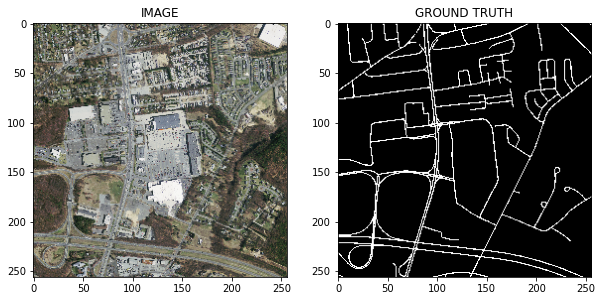

In [181]:
idx = 4

image, mask = trainset[idx]

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [182]:
from torch.utils.data import DataLoader

In [183]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [184]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 30
Total no. of batches in validloader : 10


In [185]:
for images, masks in trainloader:
  print(f"One batche image shape : {images.shape}")
  print(f"One batche mask shape : {masks.shape}")
  break;

One batche image shape : torch.Size([4, 3, 256, 256])
One batche mask shape : torch.Size([4, 1, 256, 256])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [186]:
import segmentation_models_pytorch as smp 
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [187]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits

In [188]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function 

In [189]:
def train_fn(dataloader, model, optimizer):
  model.train() # Turn ON dropout, batchnorm, etc..

  total_loss = 0.0

  for images, masks in tqdm(dataloader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [190]:
def eval_fn(dataloader, model):
  model.eval() # Turn ON dropout, batchnorm, etc..

  total_loss = 0.0


  with torch.no_grad():

    for images, masks in tqdm(dataloader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

    return total_loss / len(dataloader)

# Task 8 : Train Model

In [191]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [192]:
best_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), "best-model.pt")
    print("SAVED-MODEL")
    best_loss = valid_loss

  print(f"Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}")

100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


SAVED-MODEL
Epoch : 1 Train Loss : 1.1708772361278534 Valid Loss : 1.0705661654472352


100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


SAVED-MODEL
Epoch : 2 Train Loss : 0.9578887820243835 Valid Loss : 0.9307517409324646


100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


SAVED-MODEL
Epoch : 3 Train Loss : 0.921349581082662 Valid Loss : 0.9107616424560547


100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


SAVED-MODEL
Epoch : 4 Train Loss : 0.8971245229244232 Valid Loss : 0.9078330874443055


100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


SAVED-MODEL
Epoch : 5 Train Loss : 0.8824668486913045 Valid Loss : 0.8809948980808258


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Epoch : 6 Train Loss : 0.877052350838979 Valid Loss : 0.893906044960022


100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


SAVED-MODEL
Epoch : 7 Train Loss : 0.8592839737733206 Valid Loss : 0.8554509103298187


100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


SAVED-MODEL
Epoch : 8 Train Loss : 0.8456347743670146 Valid Loss : 0.8417774915695191


100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


SAVED-MODEL
Epoch : 9 Train Loss : 0.8232371429602305 Valid Loss : 0.8327734768390656


100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


SAVED-MODEL
Epoch : 10 Train Loss : 0.82688667178154 Valid Loss : 0.7768473565578461


100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


Epoch : 11 Train Loss : 0.8233044703801473 Valid Loss : 0.801296728849411


100%|██████████| 10/10 [00:03<00:00,  2.50it/s]


Epoch : 12 Train Loss : 0.8312293271223704 Valid Loss : 0.9447199940681458


100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Epoch : 13 Train Loss : 0.8069395542144775 Valid Loss : 0.7966149389743805


100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


SAVED-MODEL
Epoch : 14 Train Loss : 0.8073934038480123 Valid Loss : 0.7634377896785736


100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


Epoch : 15 Train Loss : 0.7916233897209167 Valid Loss : 0.8218206822872162


100%|██████████| 10/10 [00:03<00:00,  2.50it/s]


Epoch : 16 Train Loss : 0.7905510246753693 Valid Loss : 0.8176769018173218


100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


Epoch : 17 Train Loss : 0.794676806529363 Valid Loss : 0.7659790277481079


100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


Epoch : 18 Train Loss : 0.7901785929997762 Valid Loss : 0.7949869275093079


100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Epoch : 19 Train Loss : 0.7981884757677714 Valid Loss : 0.7817782759666443


100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


Epoch : 20 Train Loss : 0.7923104643821717 Valid Loss : 0.8237509310245514


100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


SAVED-MODEL
Epoch : 21 Train Loss : 0.7823048671086629 Valid Loss : 0.7412035524845123


100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


SAVED-MODEL
Epoch : 22 Train Loss : 0.7819949805736541 Valid Loss : 0.7379798352718353


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Epoch : 23 Train Loss : 0.7767277141412099 Valid Loss : 0.7604612171649933


100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Epoch : 24 Train Loss : 0.7770449121793112 Valid Loss : 0.809008926153183


100%|██████████| 10/10 [00:03<00:00,  3.15it/s]

Epoch : 25 Train Loss : 0.7710691670576731 Valid Loss : 0.7785499870777131


# Task 9 : Inference

In [231]:
idx = 17

model.load_state_dict(torch.load('/content/best-model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

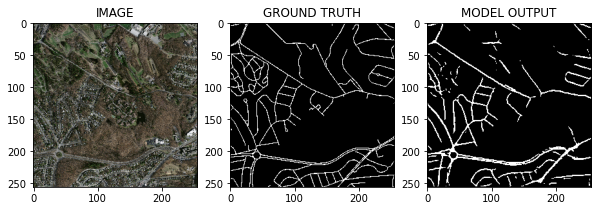

In [232]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

In [258]:
image = cv2.imread('/content/testImage002.png')

dim = (256, 256)
  
image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = np.transpose(image, (2, 0, 1)).astype(np.float32) # (c, h, w)
image = torch.Tensor(image) / 255

model.load_state_dict(torch.load('/content/best-model.pt'))
#image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0



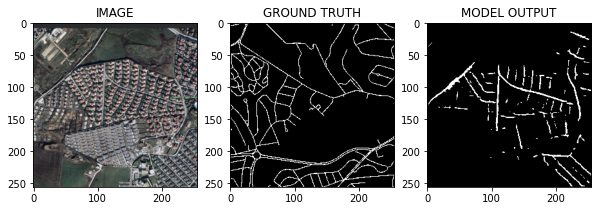

In [259]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))